# Tiny-ImageNet 图像分类实验

本实验在Tiny-ImageNet数据集上实验5个改进因子来提升图像分类性能。
实验流程与CIFAR-10实验完全一致，以验证改进因子在更复杂数据集上的表现。

## 实验设计

### 数据集特点
- **Tiny-ImageNet**: 100,000训练图像 + 10,000验证图像，64x64像素，200个类别
- 比CIFAR-10更复杂：更大的图像尺寸，更多的类别

### 5个改进因子（与CIFAR-10相同）
1. **残差连接** - 解决梯度消失问题
2. **更深/更宽的网络架构** - 增加模型容量
3. **更好的优化器和学习率调度** - 提升训练效果
4. **高级数据增强** - MixUp, CutMix
5. **注意力机制** - SE Attention

### 实验流程
1. 基线模型训练和评估
2. 逐个添加改进因子，记录性能变化
3. 分析每个因子的贡献
4. 组合最佳因子进行最终实验

In [ ]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import time
import os

# 导入自定义模块 - 使用TinyImageNet版本的models
from models_imagenet import get_model
from dataset_utils import get_dataset_loaders
from training_utils import (
    train_model, get_optimizer, get_scheduler, 
    get_optimizer_config, get_scheduler_config
)
from data_augmentation import get_transforms

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# ==================== 多GPU配置 ====================
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"检测到 {gpu_count} 个GPU:")
    for i in range(gpu_count):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
    device = torch.device("cuda:0")
    use_multi_gpu = gpu_count > 1
else:
    device = torch.device("cpu")
    use_multi_gpu = False
    gpu_count = 1

print(f"\n主设备: {device}")
print(f"多GPU训练: {'启用' if use_multi_gpu else '未启用 (单卡/CPU)'}")

使用设备: cuda:0


## 实验配置

In [ ]:
# 实验配置
config = {
    'dataset': 'tiny_imagenet',
    'batch_size': 64 * gpu_count,  # 多GPU时每个GPU处理64张图像
    'num_workers': 4 * gpu_count,  # 多GPU时增加数据加载worker
    'num_epochs': 50,
    'print_every': 1,  # 这里print的是epoch
}

# 模型配置
models_to_test = [
    'baseline',          # 基线模型
    'residual',          # 改进因子(a): 残差连接
    'deeper_wider',      # 改进因子(b): 更深更宽网络
    'se_attention',      # 改进因子(e): SE注意力
]

# 优化器配置 - 改进因子(c)
optimizer_configs = {
    'Adam': {'optimizer': 'Adam', 'scheduler': None},
    'AdamW': {'optimizer': 'AdamW', 'scheduler': 'cosine'},
    'RMSprop': {'optimizer': 'RMSprop', 'scheduler': 'cosine'},
}

# 数据增强配置 - 改进因子(d)
augmentation_configs = {
    'basic': 'basic',
    'mixup': 'mixup',
    'cutmix': 'cutmix',
}

print("实验配置完成")
print(f"  - Batch Size: {config['batch_size']} ({'每GPU '+str(config['batch_size']//gpu_count) if use_multi_gpu else '单卡'})")
print(f"  - Num Workers: {config['num_workers']}")
print(f"  - Num Epochs: {config['num_epochs']}")

# ==================== 多GPU模型包装函数 ====================
def wrap_model_multi_gpu(model, use_multi_gpu=use_multi_gpu):
    """
    如果有多个GPU，将模型包装为DataParallel
    
    参数:
        model: 要包装的模型
        use_multi_gpu: 是否使用多GPU
    
    返回:
        包装后的模型
    """
    if use_multi_gpu:
        print(f"使用 DataParallel 在 {gpu_count} 个GPU上训练")
        model = nn.DataParallel(model)
    else:
        print(f"使用单设备训练")
    return model

实验配置完成


## 1. 基线模型实验

In [7]:
# 加载数据
train_loader, test_loader, num_classes = get_dataset_loaders(
    config['dataset'], 
    batch_size=config['batch_size'],
    num_workers=config['num_workers'],
    augmentation_type='basic'
)

print(f"数据集: {config['dataset']}")
print(f"类别数: {num_classes}")
print(f"训练集大小: {len(train_loader.dataset)}")
print(f"测试集大小: {len(test_loader.dataset)}")

数据集: tiny_imagenet
类别数: 200
训练集大小: 100000
测试集大小: 10000


In [ ]:
# 基线模型实验
print("=== 基线模型实验 ===")

# 创建基线模型
baseline_model = get_model('baseline', num_classes)
baseline_model = wrap_model_multi_gpu(baseline_model)
baseline_model = baseline_model.to(device)

# 配置优化器
optimizer_config = get_optimizer_config('Adam')
optimizer = get_optimizer(baseline_model, 'Adam', **optimizer_config)

# 损失函数
criterion = nn.CrossEntropyLoss()

# 训练模型
baseline_history = train_model(
    baseline_model, train_loader, test_loader,
    config['num_epochs'], optimizer, criterion, device,
    print_every=config['print_every']
)

baseline_acc = max(baseline_history['test_acc'])
print(f"\n基线模型最佳测试准确率: {baseline_acc:.2f}%")

# 保存结果
all_results = {'baseline': baseline_acc}

=== 基线模型实验 ===
开始训练，使用设备: cuda:0 (NVIDIA GeForce RTX 5090)
模型参数量: 13.59M
Epoch   1/50: Train Loss: 5.1674, Train Acc: 1.07%, Test Loss: 4.9809, Test Acc: 2.17%, LR: 0.000300, Time: 24.10s
Epoch   2/50: Train Loss: 4.9342, Train Acc: 2.69%, Test Loss: 4.7720, Test Acc: 3.80%, LR: 0.000300, Time: 23.01s
Epoch   3/50: Train Loss: 4.7053, Train Acc: 4.54%, Test Loss: 4.3984, Test Acc: 6.94%, LR: 0.000300, Time: 23.48s
Epoch   4/50: Train Loss: 4.5693, Train Acc: 6.04%, Test Loss: 4.2571, Test Acc: 8.52%, LR: 0.000300, Time: 23.18s
Epoch   5/50: Train Loss: 4.4737, Train Acc: 7.11%, Test Loss: 4.1250, Test Acc: 10.62%, LR: 0.000300, Time: 22.98s
Epoch   6/50: Train Loss: 4.3914, Train Acc: 8.05%, Test Loss: 4.0180, Test Acc: 12.29%, LR: 0.000300, Time: 23.33s
Epoch   7/50: Train Loss: 4.3272, Train Acc: 9.06%, Test Loss: 3.9309, Test Acc: 13.64%, LR: 0.000300, Time: 23.06s
Epoch   8/50: Train Loss: 4.2639, Train Acc: 9.80%, Test Loss: 3.7995, Test Acc: 15.51%, LR: 0.000300, Time: 23.02s
Epo

## 2. 改进因子实验

### 2.1 残差连接机制 (改进因子a)


In [ ]:
print("=== 改进因子(a): 残差连接机制 ===")

# 创建带残差连接的模型
residual_model = get_model('residual', num_classes)
residual_model = wrap_model_multi_gpu(residual_model)
residual_model = residual_model.to(device)

# 使用相同的优化器配置
optimizer = get_optimizer(residual_model, 'Adam', **optimizer_config)

# 训练模型
residual_history = train_model(
    residual_model, train_loader, test_loader,
    config['num_epochs'], optimizer, criterion, device,
    print_every=config['print_every']
)

residual_acc = max(residual_history['test_acc'])
all_results['residual'] = residual_acc
print(f"\n残差模型最佳测试准确率: {residual_acc:.2f}%")
print(f"相比基线提升: {residual_acc - baseline_acc:.2f}%")


=== 改进因子(a): 残差连接机制 ===
开始训练，使用设备: cuda:0 (NVIDIA GeForce RTX 5090)
模型参数量: 9.91M


Epoch   1/50: Train Loss: 4.6449, Train Acc: 6.11%, Test Loss: 4.1076, Test Acc: 11.74%, LR: 0.000300, Time: 23.65s
Epoch   2/50: Train Loss: 4.0578, Train Acc: 12.94%, Test Loss: 3.6511, Test Acc: 18.80%, LR: 0.000300, Time: 22.70s


KeyboardInterrupt: 

### 2.2 更深更宽的网络架构 (改进因子b)

In [ ]:
print("=== 改进因子(b): 更深更宽的网络架构 ===")

# 创建更深更宽的模型
deeper_model = get_model('deeper_wider', num_classes)
deeper_model = wrap_model_multi_gpu(deeper_model)
deeper_model = deeper_model.to(device)

# 使用相同的优化器配置
optimizer = get_optimizer(deeper_model, 'Adam', **optimizer_config)

# 训练模型
deeper_history = train_model(
    deeper_model, train_loader, test_loader,
    config['num_epochs'], optimizer, criterion, device,
    print_every=config['print_every']
)

deeper_acc = max(deeper_history['test_acc'])
all_results['deeper_wider'] = deeper_acc
print(f"更深更宽模型最佳测试准确率: {deeper_acc:.2f}%")
print(f"相比基线提升: {deeper_acc - baseline_acc:.2f}%")

=== 改进因子(b): 更深更宽的网络架构 ===
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Workstation Edition)
模型参数量: 19.46M


Epoch   1/3: Train Loss: 5.2027, Train Acc: 0.96%, Test Loss: 5.1311, Test Acc: 1.09%, LR: 0.001000, Time: 31.32s
Epoch   2/3: Train Loss: 5.1392, Train Acc: 1.28%, Test Loss: 5.1143, Test Acc: 1.37%, LR: 0.001000, Time: 30.82s
Epoch   3/3: Train Loss: 5.0948, Train Acc: 1.49%, Test Loss: 5.0529, Test Acc: 1.47%, LR: 0.001000, Time: 30.53s

训练完成!
最佳测试准确率: 1.47%
总训练时间: 00:01:32 (92.67秒)
更深更宽模型最佳测试准确率: 1.47%
相比基线提升: 0.97%


### 2.3 调整优化器和学习率调度 (改进因子c)

In [ ]:
print("=== 改进因子(c): 调整优化器和学习率调度 ===")

# 测试不同的优化器配置
optimizer_results = {}

for opt_name, opt_config in optimizer_configs.items():
    if opt_name == 'Adam':
        # Adam已经在基线实验中测试过了
        optimizer_results['Adam'] = baseline_acc
        print(f"Adam (baseline): {baseline_acc:.2f}%")
        continue
    
    print(f"测试优化器: {opt_name}")
    
    # 创建新模型
    model = get_model('baseline', num_classes)
    model = wrap_model_multi_gpu(model)
    model = model.to(device)
    
    # 配置优化器
    opt_config_dict = get_optimizer_config(opt_config['optimizer'])
    optimizer = get_optimizer(model, opt_config['optimizer'], **opt_config_dict)
    
    # 配置学习率调度器
    scheduler = None
    if opt_config['scheduler']:
        scheduler_config = get_scheduler_config(opt_config['scheduler'], config['num_epochs'])
        scheduler = get_scheduler(optimizer, opt_config['scheduler'], **scheduler_config)
    
    # 训练模型
    history = train_model(
        model, train_loader, test_loader,
        config['num_epochs'], optimizer, criterion, device,
        scheduler=scheduler, print_every=config['print_every']
    )
    
    best_acc = max(history['test_acc'])
    optimizer_results[opt_name] = best_acc
    all_results[opt_name] = best_acc
    print(f"{opt_name} 最佳测试准确率: {best_acc:.2f}%")

# 找到最佳优化器
best_optimizer = max(optimizer_results, key=optimizer_results.get)
print(f"最佳优化器: {best_optimizer} (准确率: {optimizer_results[best_optimizer]:.2f}%)")
print(f"相比基线提升: {optimizer_results[best_optimizer] - baseline_acc:.2f}%")

=== 改进因子(c): 调整优化器和学习率调度 ===
Adam (baseline): 0.50%
测试优化器: AdamW
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Workstation Edition)
模型参数量: 13.60M


Epoch   1/3: Train Loss: 5.3001, Train Acc: 0.43%, Test Loss: 5.2986, Test Acc: 0.50%, LR: 0.000750, Time: 17.28s
Epoch   2/3: Train Loss: 5.2992, Train Acc: 0.45%, Test Loss: 5.2984, Test Acc: 0.50%, LR: 0.000250, Time: 17.26s
Epoch   3/3: Train Loss: 5.2987, Train Acc: 0.50%, Test Loss: 5.2984, Test Acc: 0.50%, LR: 0.000000, Time: 17.36s

训练完成!
最佳测试准确率: 0.50%
总训练时间: 00:00:51 (51.91秒)
AdamW 最佳测试准确率: 0.50%
测试优化器: RMSprop
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Workstation Edition)
模型参数量: 13.60M
Epoch   1/3: Train Loss: 25.9641, Train Acc: 0.45%, Test Loss: 5.2985, Test Acc: 0.50%, LR: 0.000750, Time: 17.21s
Epoch   2/3: Train Loss: 5.3084, Train Acc: 0.46%, Test Loss: 5.2984, Test Acc: 0.50%, LR: 0.000250, Time: 16.83s
Epoch   3/3: Train Loss: 5.2035, Train Acc: 0.81%, Test Loss: 5.1314, Test Acc: 0.97%, LR: 0.000000, Time: 17.20s

训练完成!
最佳测试准确率: 0.97%
总训练时间: 00:00:51 (51.24秒)
RMSprop 最佳测试准确率: 0.97%
最佳优化器: RMSprop (准确率: 0.97%)
相比基线提升: 0.47%


### 2.4 高级数据增强 (改进因子d)

In [ ]:
print("=== 改进因子(d): 高级数据增强 ===")

# 测试不同的数据增强方法
augmentation_results = {}
augmentation_results['basic'] = baseline_acc  # 基线已经使用了basic augmentation

for aug_name, aug_type in augmentation_configs.items():
    if aug_name == 'basic':
        print(f"basic (baseline): {baseline_acc:.2f}%")
        continue  # baseline已经有了
    
    print(f"测试数据增强: {aug_name}")
    
    # 重新加载数据（使用不同的数据增强）
    train_loader_aug, test_loader_aug, _ = get_dataset_loaders(
        config['dataset'],
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        augmentation_type=aug_type
    )
    
    # 创建模型
    model = get_model('baseline', num_classes)
    model = wrap_model_multi_gpu(model)
    model = model.to(device)
    
    # 使用 Adam 优化器（与baseline一致）
    opt_config_dict = get_optimizer_config("Adam")
    optimizer = get_optimizer(model, "Adam", **opt_config_dict)
    
    # 训练模型
    history = train_model(
        model, train_loader_aug, test_loader_aug,
        config['num_epochs'], optimizer, criterion, device,
        augmentation=aug_type,
        print_every=config['print_every']
    )
    
    best_acc = max(history['test_acc'])
    augmentation_results[aug_name] = best_acc
    all_results[aug_name] = best_acc
    print(f"{aug_name} 最佳测试准确率: {best_acc:.2f}%")

# 找到最佳数据增强方法
best_augmentation = max(augmentation_results, key=augmentation_results.get)
print(f"最佳数据增强: {best_augmentation} (准确率: {augmentation_results[best_augmentation]:.2f}%)")
print(f"相比基线提升: {augmentation_results[best_augmentation] - baseline_acc:.2f}%")

=== 改进因子(d): 高级数据增强 ===
basic (baseline): 0.50%
测试数据增强: mixup
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Workstation Edition)
模型参数量: 13.60M


Epoch   1/3: Train Loss: 5.3000, Train Acc: 0.00%, Test Loss: 5.2987, Test Acc: 0.50%, LR: 0.001000, Time: 14.52s
Epoch   2/3: Train Loss: 5.2993, Train Acc: 0.00%, Test Loss: 5.2984, Test Acc: 0.50%, LR: 0.001000, Time: 14.56s
Epoch   3/3: Train Loss: 5.2991, Train Acc: 0.00%, Test Loss: 5.2984, Test Acc: 0.50%, LR: 0.001000, Time: 14.48s

训练完成!
最佳测试准确率: 0.50%
总训练时间: 00:00:43 (43.56秒)
mixup 最佳测试准确率: 0.50%
测试数据增强: cutmix
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Workstation Edition)
模型参数量: 13.60M
Epoch   1/3: Train Loss: 5.3001, Train Acc: 0.00%, Test Loss: 5.2987, Test Acc: 0.50%, LR: 0.001000, Time: 14.66s
Epoch   2/3: Train Loss: 5.2992, Train Acc: 0.00%, Test Loss: 5.2984, Test Acc: 0.50%, LR: 0.001000, Time: 14.59s
Epoch   3/3: Train Loss: 5.2991, Train Acc: 0.00%, Test Loss: 5.2984, Test Acc: 0.50%, LR: 0.001000, Time: 14.42s

训练完成!
最佳测试准确率: 0.50%
总训练时间: 00:00:43 (43.66秒)
cutmix 最佳测试准确率: 0.50%
最佳数据增强: basic (准确率: 0.50%)
相比基线提升: 0.00%


### 2.5 注意力机制 (改进因子e)

In [ ]:
print("=== 改进因子(e): 注意力机制 ===")

# 测试SE注意力
print("测试注意力机制: se_attention")

# 创建带SE注意力的模型
se_model = get_model('se_attention', num_classes)
se_model = wrap_model_multi_gpu(se_model)
se_model = se_model.to(device)

# 使用Adam优化器（与baseline一致）
opt_config_dict = get_optimizer_config("Adam")
optimizer = get_optimizer(se_model, "Adam", **opt_config_dict)

# 训练模型
se_history = train_model(
    se_model, train_loader, test_loader,
    config['num_epochs'], optimizer, criterion, device,
    print_every=config['print_every']
)

se_acc = max(se_history['test_acc'])
all_results['se_attention'] = se_acc
print(f"SE注意力模型最佳测试准确率: {se_acc:.2f}%")
print(f"相比基线提升: {se_acc - baseline_acc:.2f}%")

=== 改进因子(e): 注意力机制 ===
测试注意力机制: se_attention
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Workstation Edition)
模型参数量: 13.69M


Epoch   1/3: Train Loss: 5.2133, Train Acc: 0.93%, Test Loss: 5.1028, Test Acc: 0.90%, LR: 0.001000, Time: 20.40s
Epoch   2/3: Train Loss: 5.1218, Train Acc: 1.40%, Test Loss: 5.1624, Test Acc: 1.21%, LR: 0.001000, Time: 20.63s
Epoch   3/3: Train Loss: 5.0514, Train Acc: 1.81%, Test Loss: 4.8778, Test Acc: 2.85%, LR: 0.001000, Time: 20.36s

训练完成!
最佳测试准确率: 2.85%
总训练时间: 00:01:01 (61.40秒)
SE注意力模型最佳测试准确率: 2.85%
相比基线提升: 2.35%


## 3. 实验结果分析

## 4. 最佳组合模型 (BestModel)

结合残差连接和更深更宽架构，使用最优超参数训练。


In [ ]:
# 训练最佳组合模型
print("=== 训练最佳组合模型 ===")

from best_model_imagenet import BestModel

# 创建模型
best_model = BestModel(num_classes=num_classes)
best_model = wrap_model_multi_gpu(best_model)
best_model = best_model.to(device)

# 获取参数量（处理DataParallel的情况）
model_for_params = best_model.module if isinstance(best_model, nn.DataParallel) else best_model
print(f"最佳模型参数量: {model_for_params.get_num_params() / 1_000_000:.2f}M")

# 使用最优配置: Adam优化器, lr=3e-4, weight_decay=1e-6 (来自CIFAR-10的最佳配置)
optimizer = optim.Adam(best_model.parameters(), lr=3e-4, weight_decay=1e-6)

# 训练模型
best_combined_history = train_model(
    best_model, train_loader, test_loader,
    config['num_epochs'], optimizer, criterion, device,
    print_every=config['print_every']
)

best_combined_acc = max(best_combined_history['test_acc'])
all_results['best_combined'] = best_combined_acc
print(f"\n最佳组合模型最佳测试准确率: {best_combined_acc:.2f}%")
print(f"相比基线提升: {best_combined_acc - baseline_acc:.2f}%")


=== 训练最佳组合模型 ===
最佳模型参数量: 20.14M
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Workstation Edition)
模型参数量: 20.14M
Epoch   1/3: Train Loss: 5.1215, Train Acc: 1.57%, Test Loss: 4.8868, Test Acc: 2.93%, LR: 0.000300, Time: 36.21s
Epoch   2/3: Train Loss: 4.8473, Train Acc: 3.30%, Test Loss: 4.5846, Test Acc: 4.68%, LR: 0.000300, Time: 36.60s
Epoch   3/3: Train Loss: 4.6596, Train Acc: 4.72%, Test Loss: 4.4260, Test Acc: 6.60%, LR: 0.000300, Time: 36.63s

训练完成!
最佳测试准确率: 6.60%
总训练时间: 00:01:49 (109.44秒)

最佳组合模型最佳测试准确率: 6.60%
相比基线提升: 6.10%


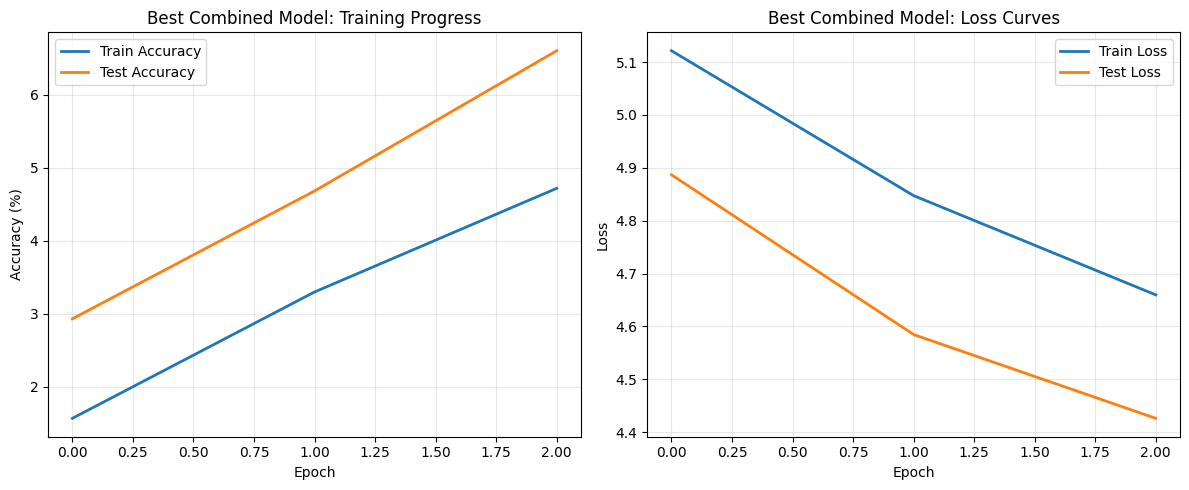

=== 最佳组合模型详细结果 ===
模型名称: Deeper/Wider + Residual
模型参数量: 20.14M
最佳测试准确率: 6.60%
最终训练准确率: 4.72%
最终测试准确率: 6.60%

相比各个单独因子的提升:
  vs Baseline: +6.10%
  vs Residual: +-10.76%
  vs Deeper/Wider: +5.13%


In [ ]:
# 可视化最佳模型的训练过程
plt.figure(figsize=(12, 5))

# 训练和测试准确率
plt.subplot(1, 2, 1)
plt.plot(best_combined_history['train_acc'], label='Train Accuracy', linewidth=2)
plt.plot(best_combined_history['test_acc'], label='Test Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Best Combined Model: Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

# 训练和测试损失
plt.subplot(1, 2, 2)
plt.plot(best_combined_history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(best_combined_history['test_loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Best Combined Model: Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./figure/tinyimagenet_best_model.png', dpi=150, bbox_inches='tight')
plt.show()

# 打印详细结果
print(f"=== 最佳组合模型详细结果 ===")
print(f"模型名称: Deeper/Wider + Residual")
print(f"模型参数量: {best_model.get_num_params() / 1_000_000:.2f}M")
print(f"最佳测试准确率: {best_combined_acc:.2f}%")
print(f"最终训练准确率: {best_combined_history['train_acc'][-1]:.2f}%")
print(f"最终测试准确率: {best_combined_history['test_acc'][-1]:.2f}%")
print(f"\n相比各个单独因子的提升:")
print(f"  vs Baseline: +{best_combined_acc - all_results['baseline']:.2f}%")
print(f"  vs Residual: +{best_combined_acc - all_results['residual']:.2f}%")
print(f"  vs Deeper/Wider: +{best_combined_acc - all_results['deeper_wider']:.2f}%")


## 5. 保存和加载模型


In [ ]:
# 保存最佳模型参数
import os

# 创建保存目录
save_dir = './saved_models'
os.makedirs(save_dir, exist_ok=True)

# 获取实际的模型（处理DataParallel）
model_to_save = best_model.module if isinstance(best_model, nn.DataParallel) else best_model

# 保存模型参数
model_path = os.path.join(save_dir, 'best_model_tinyimagenet.pth')
torch.save(model_to_save.state_dict(), model_path)
print(f"模型参数已保存到: {model_path}")

# 保存完整的模型信息（包括超参数）
checkpoint = {
    'model_state_dict': model_to_save.state_dict(),
    'model_name': 'BestModel (Deeper/Wider + Residual)',
    'num_params': model_to_save.get_num_params(),
    'best_accuracy': best_combined_acc,
    'final_train_acc': best_combined_history['train_acc'][-1],
    'final_test_acc': best_combined_history['test_acc'][-1],
    'optimizer': 'Adam',
    'lr': 3e-4,
    'weight_decay': 1e-6,
    'augmentation': 'basic',
    'num_epochs': config['num_epochs'],
    'history': best_combined_history,
    'dataset': 'tiny_imagenet',
    'num_classes': 200
}

checkpoint_path = os.path.join(save_dir, 'best_model_tinyimagenet_checkpoint.pth')
torch.save(checkpoint, checkpoint_path)
print(f"完整检查点已保存到: {checkpoint_path}")

模型参数已保存到: ./saved_models/best_model_tinyimagenet.pth
完整检查点已保存到: ./saved_models/best_model_tinyimagenet_checkpoint.pth


In [ ]:
def load_best_model(device='cuda' if torch.cuda.is_available() else 'cpu', 
                    load_checkpoint=False):
    """
    加载训练好的最佳模型
    
    参数:
        device: 设备 ('cuda' 或 'cpu')
        load_checkpoint: 是否加载完整检查点（包括训练历史等）
    
    返回:
        model: 装载了最优参数的 BestModel
        checkpoint (可选): 如果 load_checkpoint=True，返回完整的检查点字典
    """
    from best_model_imagenet import BestModel
    
    # 创建模型实例
    model = BestModel(num_classes=200).to(device)
    
    save_dir = './saved_models'
    
    if load_checkpoint:
        # 加载完整检查点
        checkpoint_path = os.path.join(save_dir, 'best_model_tinyimagenet_checkpoint.pth')
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        print(f"已加载最佳模型检查点")
        print(f"  - 模型名称: {checkpoint['model_name']}")
        print(f"  - 参数量: {checkpoint['num_params'] / 1_000_000:.2f}M")
        print(f"  - 最佳测试准确率: {checkpoint['best_accuracy']:.2f}%")
        print(f"  - 最终测试准确率: {checkpoint['final_test_acc']:.2f}%")
        print(f"  - 优化器: {checkpoint['optimizer']}")
        print(f"  - 学习率: {checkpoint['lr']}")
        print(f"  - 权重衰减: {checkpoint['weight_decay']}")
        print(f"  - 数据增强: {checkpoint['augmentation']}")
        
        return model, checkpoint
    else:
        # 仅加载模型参数
        model_path = os.path.join(save_dir, 'best_model_tinyimagenet.pth')
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=False))
        
        print(f"已加载最佳模型参数")
        print(f"  - 模型参数量: {model.get_num_params() / 1_000_000:.2f}M")
        print(f"  - 设备: {device}")
        
        return model


# 测试加载函数
print("=== 测试模型加载 ===\n")

# 方式1：仅加载模型参数
print("方式1：仅加载模型参数")
loaded_model = load_best_model(device=device)

# 方式2：加载完整检查点
print("\n" + "="*50 + "\n")
print("方式2：加载完整检查点（包括训练历史）")
loaded_model_with_checkpoint, checkpoint_data = load_best_model(device=device, load_checkpoint=True)

# 验证模型是否正确加载（在测试集上评估）
from training_utils import evaluate

print("\n" + "="*50 + "\n")
print("验证加载的模型性能:")
loaded_model.eval()
test_loss, test_acc = evaluate(loaded_model, test_loader, criterion, device)
print(f"测试准确率: {test_acc:.2f}%")
print(f"原始最佳准确率: {best_combined_acc:.2f}%")


=== 测试模型加载 ===

方式1：仅加载模型参数
已加载最佳模型参数
  - 模型参数量: 20.14M
  - 设备: cuda:0


方式2：加载完整检查点（包括训练历史）
已加载最佳模型检查点
  - 模型名称: BestModel (Deeper/Wider + Residual)
  - 参数量: 20.14M
  - 最佳测试准确率: 6.60%
  - 最终测试准确率: 6.60%
  - 优化器: Adam
  - 学习率: 0.0003
  - 权重衰减: 1e-06
  - 数据增强: basic


验证加载的模型性能:


测试准确率: 6.60%
原始最佳准确率: 6.60%


In [ ]:
# 创建结果DataFrame
results_data = []
for method, acc in all_results.items():
    results_data.append({
        'Method': method,
        'Accuracy': acc,
        'Improvement': acc - baseline_acc
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("=== Tiny-ImageNet 实验结果汇总 ===")
print(results_df.to_string(index=False))

# 计算各改进因子的贡献
print(f"=== 改进因子贡献分析 ===")
print(f"基线模型准确率: {baseline_acc:.2f}%")
print(f"残差连接提升: {all_results['residual'] - baseline_acc:.2f}%")
print(f"更深更宽网络提升: {all_results['deeper_wider'] - baseline_acc:.2f}%")
print(f"最佳优化器({best_optimizer})提升: {optimizer_results[best_optimizer] - baseline_acc:.2f}%")
print(f"最佳数据增强({best_augmentation})提升: {augmentation_results[best_augmentation] - baseline_acc:.2f}%")
print(f"SE注意力提升: {all_results['se_attention'] - baseline_acc:.2f}%")

=== Tiny-ImageNet 实验结果汇总 ===
       Method  Accuracy  Improvement
     residual     17.36        16.86
best_combined      6.60         6.10
 se_attention      2.85         2.35
 deeper_wider      1.47         0.97
      RMSprop      0.97         0.47
     baseline      0.50         0.00
        AdamW      0.50         0.00
       cutmix      0.50         0.00
        mixup      0.50         0.00
=== 改进因子贡献分析 ===
基线模型准确率: 0.50%
残差连接提升: 16.86%
更深更宽网络提升: 0.97%
最佳优化器(RMSprop)提升: 0.47%
最佳数据增强(basic)提升: 0.00%
SE注意力提升: 2.35%


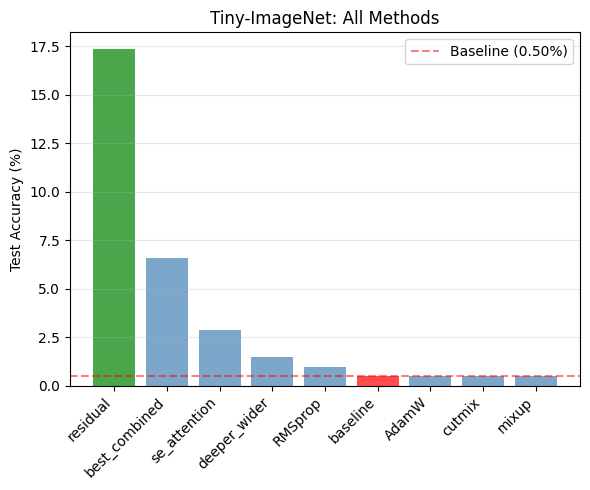

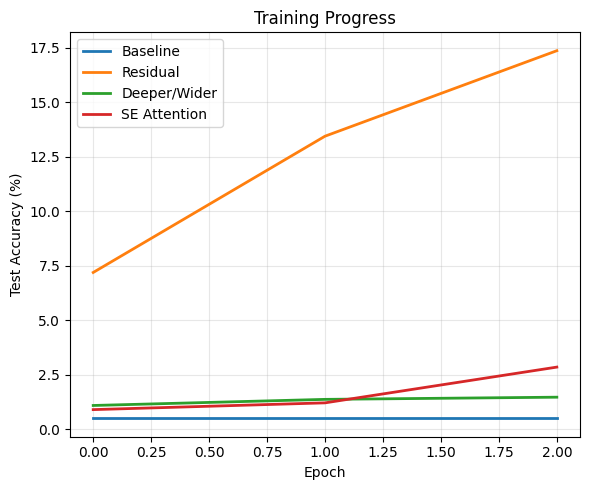

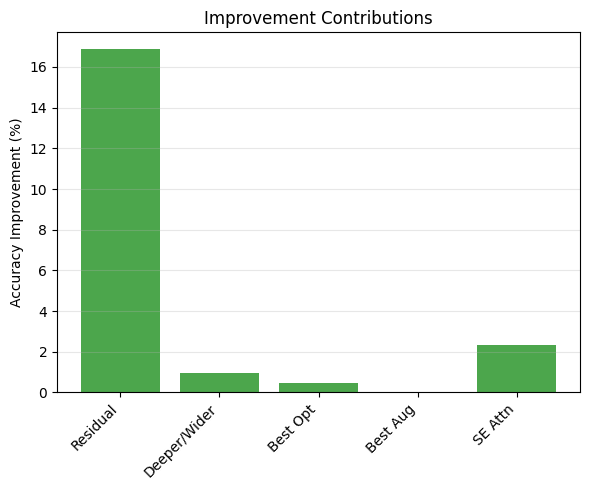

单独结果图已保存为 tinyimagenet_accuracy_comparison.png, tinyimagenet_training_progress.png, tinyimagenet_improvement_contributions.png


In [ ]:
# 1. 各方法准确率对比
plt.figure(figsize=(6, 5))
colors = ['red' if method == 'baseline' else 'green' if acc == results_df['Accuracy'].max() else 'steelblue' 
          for method, acc in zip(results_df['Method'], results_df['Accuracy'])]
bars = plt.bar(range(len(results_df)), results_df['Accuracy'], color=colors, alpha=0.7)
plt.xticks(range(len(results_df)), results_df['Method'], rotation=45, ha='right')
plt.ylabel('Test Accuracy (%)')
plt.title('Tiny-ImageNet: All Methods')
plt.axhline(y=baseline_acc, color='red', linestyle='--', alpha=0.5, label=f'Baseline ({baseline_acc:.2f}%)')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('./figure/tinyimagenet_accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 2. 训练曲线对比
plt.figure(figsize=(6, 5))
plt.plot(baseline_history['test_acc'], label='Baseline', linewidth=2)
plt.plot(residual_history['test_acc'], label='Residual', linewidth=2)
plt.plot(deeper_history['test_acc'], label='Deeper/Wider', linewidth=2)
plt.plot(se_history['test_acc'], label='SE Attention', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./figure/tinyimagenet_training_progress.png', dpi=150, bbox_inches='tight')
plt.show()

# 3. 改进因子贡献
plt.figure(figsize=(6, 5))
improvements = {
    'Residual': all_results['residual'] - baseline_acc,
    'Deeper/Wider': all_results['deeper_wider'] - baseline_acc,
    f'Best Opt': optimizer_results[best_optimizer] - baseline_acc,
    f'Best Aug': augmentation_results[best_augmentation] - baseline_acc,
    'SE Attn': all_results['se_attention'] - baseline_acc
}
colors_imp = ['green' if v > 0 else 'red' for v in improvements.values()]
plt.bar(improvements.keys(), improvements.values(), color=colors_imp, alpha=0.7)
plt.ylabel('Accuracy Improvement (%)')
plt.title('Improvement Contributions')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('./figure/tinyimagenet_improvement_contributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("单独结果图已保存为 tinyimagenet_accuracy_comparison.png, tinyimagenet_training_progress.png, tinyimagenet_improvement_contributions.png")